In [1]:
# Đánh giá mô hình
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve,
    confusion_matrix,
    classification_report
)

from sklearn.model_selection import cross_val_score

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [2]:
DATA_PATH = '/content/drive/MyDrive/DS102 - Machine Learning/Hotel/data/'
MODEL_PATH = '/content/drive/MyDrive/DS102 - Machine Learning/Hotel/models/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dữ liệu

In [4]:
X_test = pd.read_csv(DATA_PATH + 'X_test.csv')
y_test = pd.read_csv(DATA_PATH + 'y_test.csv')
X_dev = pd.read_csv(DATA_PATH + 'X_dev.csv')
y_dev = pd.read_csv(DATA_PATH + 'y_dev.csv')
X_train = pd.read_csv(DATA_PATH + 'X_train.csv')
y_train = pd.read_csv(DATA_PATH + 'y_train.csv')

# Các mô hình

In [5]:
log_reg = joblib.load(MODEL_PATH + 'model_logreg.pkl')
rf = joblib.load(MODEL_PATH + 'model_randomforest.pkl')
xgb = joblib.load(MODEL_PATH + 'XGBoost_model.pkl')

In [6]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'XGBoost': xgb
}

In [7]:
log_cols = ['lead_time']
ohe_cols = ['market_segment', 'distribution_channel',
            'assigned_room_type', 'customer_type', 'hotel_type',
            'country_group']
ordinal_cols = [
    'previous_cancellations_group',
    'previous_bookings_not_canceled_group',
    'booking_changes_group',
    'days_in_waiting_list_group',
    'deposit_type'
]

ordinal_categories = [
    ['0', '1-5', '>5'],                 # previous_cancellations_group
    ['0', '1-5', '>5'],                 # previous_bookings_not_canceled_group
    ['0', '1-2', '>2'],                 # booking_changes_group
    ['no_wait', 'short', 'medium', 'long', 'very_long'],
    ['No Deposit', 'Refundable', 'Non Refund'] # không đặt cọc, có hoàn tiền , ko hoàn tiền
]

In [8]:
class LogTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return np.log1p(X)

  def get_feature_names_out(self, input_features=None):
    return np.array([f'log_{feature}' for feature in input_features])


ohe_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

ord_transformer = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log', LogTransformer(), log_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('ord', ord_transformer, ordinal_cols)
    ],
    remainder='passthrough'
)
preprocessor.fit(X_train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('log', LogTransformer(), ['lead_time']),
                                ('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['market_segment', 'distribution_channel',
                                  'assigned_room_type', 'customer_type',
                                  'hotel_type', 'country_group']),
                                ('ord',
                                 OrdinalEncoder(categories=[['0', '1-5', '>5'],
                                                            ['0', '1-5', '>5'],
                                                            ['0', '1-2', '>2'],
                                                            ['no_wait', 'short',
                                                             'medium', 'long',
                                                             'very_long'],
                                                            ['No Deposit',
                                                             'Refundable',
                                                             'Non Refund']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['previous_cancellations_group',
                                  'previous_bookings_not_canceled_group',
                                  'booking_changes_group',
                                  'days_in_waiting_list_group',
                                  'deposit_type'])])

# Đánh giá các mô hình trên tập dev

In [10]:
X_dev_trans = preprocessor.transform(X_dev)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [11]:
results = []

for model_name, model in models.items():
    y_pred = model.predict(X_dev_trans)
    y_prob = model.predict_proba(X_dev_trans)[:, 1]

    accuracy = accuracy_score(y_dev, y_pred)
    precision = precision_score(y_dev, y_pred)
    recall = recall_score(y_dev, y_pred)
    f1 = f1_score(y_dev, y_pred)
    auc = roc_auc_score(y_dev, y_prob)

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    })

In [12]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.815929,0.729910,0.811109,0.768370,0.902766
1,Random Forest,0.857346,0.799620,0.828667,0.813884,0.937797
2,XGBoost,0.857574,0.790247,0.846224,0.817278,0.939186


## So sánh với kết quả đánh giá trên tập train

In [13]:
X_train_trans = preprocessor.transform(X_train)

In [14]:
for model_name, model in models.items():
  y_pred_train = model.predict(X_train_trans)
  y_prob_train = model.predict_proba(X_train_trans)[:, 1]

  y_pred_dev = model.predict(X_dev_trans)
  y_prob_dev = model.predict_proba(X_dev_trans)[:, 1]

  recall_train = recall_score(y_train, y_pred_train)
  recall_dev = recall_score(y_dev, y_pred_dev)

  auc_train = roc_auc_score(y_train, y_prob_train)
  auc_dev = roc_auc_score(y_dev, y_prob_dev)

  f1_train = f1_score(y_train, y_pred_train)
  f1_dev = f1_score(y_dev, y_pred_dev)

  print("="*50)
  print(f'Model: {model_name}')
  print()
  print(f'Recall train: {recall_train}')
  print(f'Recall dev: {recall_dev}')
  print()
  print(f'AUC train: {auc_train}')
  print(f'AUC dev: {auc_dev}')
  print()
  print(f'F1 train: {f1_train}')
  print(f'F1 dev: {f1_dev}')

  print('-'*10)
  f1_cross_val = cross_val_score(model, X_train_trans, y_train, cv=5, scoring='f1').mean()
  print(f'F1 cross val: {f1_cross_val}')

Model: Logistic Regression

Recall train: 0.8065035309574643
Recall dev: 0.811109429393068

AUC train: 0.904918470044436
AUC dev: 0.9027656884128482

F1 train: 0.7678764092380341
F1 dev: 0.7683704925084236
----------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

F1 cross val: 0.7669119504662649
Model: Random Forest

Recall train: 0.8684841517490557
Recall dev: 0.8286665657635841

AUC train: 0.9623700038822953
AUC dev: 0.9377973770600427

F1 train: 0.8478212075544297
F1 dev: 0.8138843466627026
----------


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

F1 cross val: 0.8093632505459452
Model: XGBoost

Recall train: 0.9007718837247496
Recall dev: 0.8462237021341001

AUC train: 0.9685856450092039
AUC dev: 0.9391857923223741

F1 train: 0.8658205468207363
F1 dev: 0.8172781757053063
----------
F1 cross val: 0.8110042641924192


In [15]:
roc_auc = {}
precion_recall_curve = {}

for model_name, model in models.items():

  # ROC - AUC
  y_prob = model.predict_proba(X_dev_trans)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_dev, y_prob)
  auc = roc_auc_score(y_dev, y_prob)
  roc_auc[model_name] = (fpr, tpr, auc)

  # Precision, recall curve
  precision, recall, thresholds = precision_recall_curve(y_dev, y_prob)
  ap = average_precision_score(y_dev, y_prob)
  precion_recall_curve[model_name] = (recall, precision, ap)

### Đường cong ROC và diện tích dưới đường cong ROC (AUC)

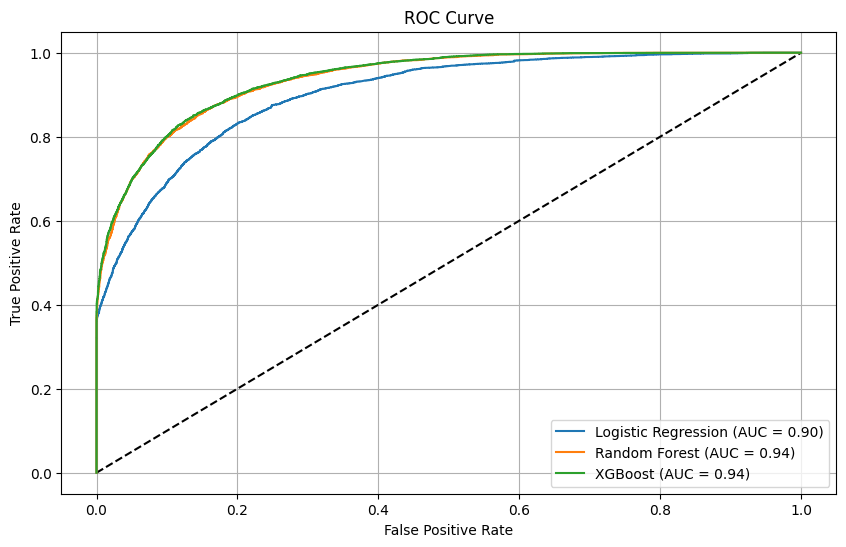

In [16]:
plt.figure(figsize=(10, 6))
for model_name, (fpr, tpr, auc) in roc_auc.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})', zorder=3)
plt.plot([0,1],[0,1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True, zorder=0)
plt.legend()
plt.show()

Biểu đồ ROC cho thấy sự khác biệt rõ rệt về khả năng phân loại giữa ba mô hình:

- Logistic Regression đạt AUC = 0.90, cho thấy mô hình tuyến tính này có hiệu suất tốt và dễ giải thích, nhưng khả năng phân biệt giữa hai lớp còn hạn chế so với các mô hình phi tuyến.

- Random Forest đạt AUC = 0.94, là mô hình có hiệu suất cao nhất. Nhờ cấu trúc cây ngẫu nhiên và khả năng học phi tuyến, mô hình này phân biệt lớp rất tốt.

- XGBoost đạt AUC = 0.94, tương đương với Random Forest.

## Đường cong Precion, Recall

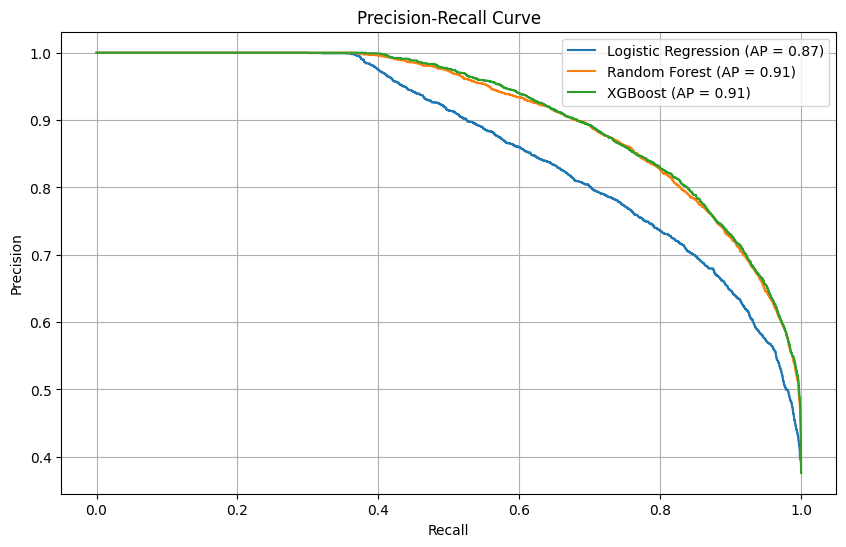

In [17]:
plt.figure(figsize=(10, 6))
for model_name, (recall, precision, ap) in precion_recall_curve.items():
    plt.plot(recall, precision, label=f'{model_name} (AP = {ap:.2f})', zorder=3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, zorder=0)
plt.legend()
plt.show()

Biểu đồ Precision-Recall cho thấy sự khác biệt về khả năng cân bằng giữa độ chính xác (Precision) và Recall của ba mô hình:

- Logistic Regression đạt Average Precision = 0.87, cho thấy mô hình tuyến tính này có hiệu suất ổn định, nhưng thấp hơn so với các mô hình phi tuyến.

- Random Forest đạt AP = 0.91, thể hiện khả năng phân loại mạnh mẽ, đặc biệt trong việc duy trì độ chính xác cao khi Recall tăng.

- XGBoost cũng đạt AP = 0.91, cho thấy hiệu suất tương đương với Random Forest.

# Dự đoán và đánh giá trên test

In [18]:
X_test_trans = preprocessor.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [19]:
y_pred_test = xgb.predict(X_test_trans)
y_prob_test = xgb.predict_proba(X_test_trans)[:, 1]

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88     11074
           1       0.78      0.85      0.81      6479

    accuracy                           0.86     17553
   macro avg       0.84      0.85      0.85     17553
weighted avg       0.86      0.86      0.86     17553



In [20]:
confusion_matrix(y_test, y_pred_test)

array([[9525, 1549],
       [ 990, 5489]])

In [21]:
print('F1 score: ', f1_score(y_test, y_pred_test))
print('AUC: ', roc_auc_score(y_test, y_prob_test))
print('Recall: ', recall_score(y_test, y_pred_test))
print('Precision: ', precision_score(y_test, y_pred_test))
print('Accuracy: ', accuracy_score(y_test, y_pred_test))

F1 score:  0.8121624620847822
AUC:  0.9402965814757855
Recall:  0.8471986417657046
Precision:  0.7799090650753054
Accuracy:  0.8553523614197004


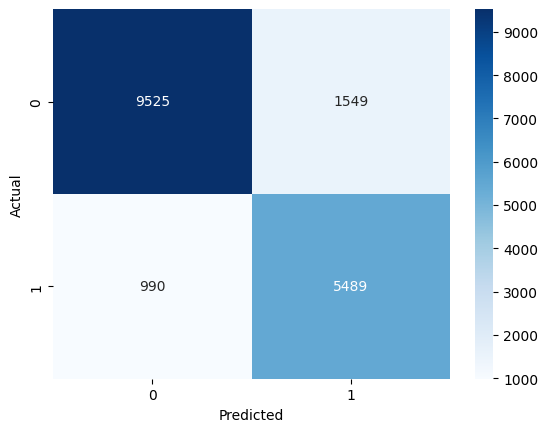

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

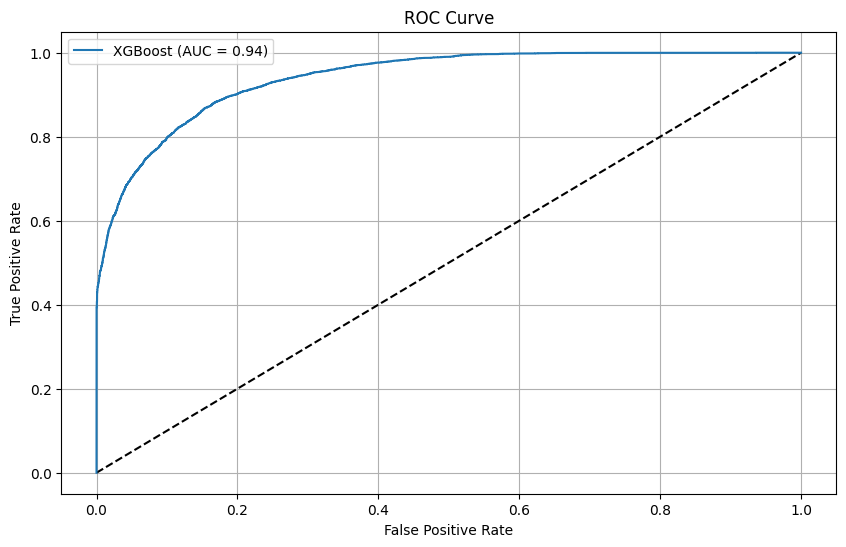

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
auc = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})', zorder=3)
plt.plot([0,1],[0,1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True, zorder=0)
plt.legend()
plt.show()

Kết quả cho thấy mô hình đạt hiệu suất rất tốt và ổn định khi áp dụng trên dữ liệu chưa từng thấy:

* F1 Score = 0.812 -> Mức cân bằng tốt giữa Precision và Recall, phù hợp với bài toán có nhãn lệch và yêu cầu phát hiện chính xác các trường hợp Huỷ.

* AUC ROC = 0.94 -> Khả năng phân biệt giữa hai lớp rất mạnh, gần đạt mức tối ưu.

* Recall = 0.847 -> Mô hình phát hiện được hơn 85% các trường hợp thực sự Huỷ, giúp giảm bỏ sót.

* Precision = 0.78 -> Trong các dự đoán Huỷ, gần 78% là chính xác, hạn chế cảnh báo sai.

* Accuracy = 0.855 -> Tổng thể mô hình phân loại đúng hơn 85% các trường hợp.

Mô hình tổng quát hóa tốt, không bị overfitting, và duy trì hiệu suất cao trên tập test.

F1 score và AUC cao cho thấy mô hình phù hợp với bài toán ban đầu.

In [24]:
X_test_predicted = pd.concat([X_test, pd.Series(y_pred_test.squeeze(), name='predicted'), pd.Series(y_prob_test.squeeze(), name='proba'), pd.Series(y_test.squeeze(), name='actual')], axis=1)

In [25]:
X_test_false_negative = X_test_predicted[(X_test_predicted['predicted'] == 0) & (X_test_predicted['actual'] == 1)].copy()

In [26]:
X_test_false_negative

,lead_time,market_segment,distribution_channel,assigned_room_type,deposit_type,customer_type,required_car_parking_spaces,total_of_special_requests,has_company,has_agent,...,previous_bookings_not_canceled_group,booking_changes_group,days_in_waiting_list_group,total_guests,total_stays,is_different_room,country_group,predicted,proba,actual
20,0,Online TA,TA/TO,F,No Deposit,Transient,0,0,0,1,...,0,0,no_wait,2,2,1,PRT,0,0.310921,1
26,150,Offline TA/TO,TA/TO,A,No Deposit,Transient-Party,0,0,0,1,...,0,1-2,no_wait,1,3,0,PRT,0,0.479710,1
51,16,Online TA,TA/TO,A,No Deposit,Transient,0,1,0,1,...,0,0,no_wait,2,2,0,DEU,0,0.275199,1
54,24,Offline TA/TO,TA/TO,A,No Deposit,Transient-Party,0,0,0,0,...,0,0,no_wait,1,7,0,GBR,0,0.305825,1
56,320,Online TA,TA/TO,A,No Deposit,Transient-Party,0,1,0,1,...,0,0,no_wait,2,7,0,IRL,0,0.255152,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17528,69,Direct,Direct,A,No Deposit,Transient,0,2,0,1,...,0,0,no_wait,2,4,0,FRA,0,0.164994,1
17529,59,Online TA,TA/TO,A,No Deposit,Transient,0,2,0,1,...,0,0,no_wait,2,7,0,IRL,0,0.341512,1
17530,13,Direct,Direct,A,No Deposit,Transient,0,1,0,0,...,0,0,no_wait,2,2,0,PRT,0,0.454860,1
17537,2,Offline TA/TO,GDS,E,No Deposit,Transient,0,0,0,1,...,0,0,no_wait,1,1,0,CHE,0,0.263671,1


## Phân tích dựa trên SHAP value

In [27]:
import shap

In [28]:
X_test_trans = preprocessor.transform(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [29]:
feature_names = preprocessor.get_feature_names_out()

In [30]:
feature_names

array(['log__log_lead_time', 'ohe__market_segment_Complementary',
       'ohe__market_segment_Corporate', 'ohe__market_segment_Direct',
       'ohe__market_segment_Groups', 'ohe__market_segment_Offline TA/TO',
       'ohe__market_segment_Online TA',
       'ohe__distribution_channel_Direct',
       'ohe__distribution_channel_GDS', 'ohe__distribution_channel_TA/TO',
       'ohe__distribution_channel_Undefined', 'ohe__assigned_room_type_B',
       'ohe__assigned_room_type_C', 'ohe__assigned_room_type_D',
       'ohe__assigned_room_type_E', 'ohe__assigned_room_type_F',
       'ohe__assigned_room_type_G', 'ohe__assigned_room_type_H',
       'ohe__assigned_room_type_I', 'ohe__assigned_room_type_K',
       'ohe__assigned_room_type_L', 'ohe__customer_type_Group',
       'ohe__customer_type_Transient',
       'ohe__customer_type_Transient-Party', 'ohe__hotel_type_Resort',
       'ohe__country_group_BEL', 'ohe__country_group_BRA',
       'ohe__country_group_CHE', 'ohe__country_group_CN',
      

In [31]:
explainer = shap.TreeExplainer(
    xgb,
    feature_names=feature_names
)

In [32]:
shap_values = explainer(X_test_trans)

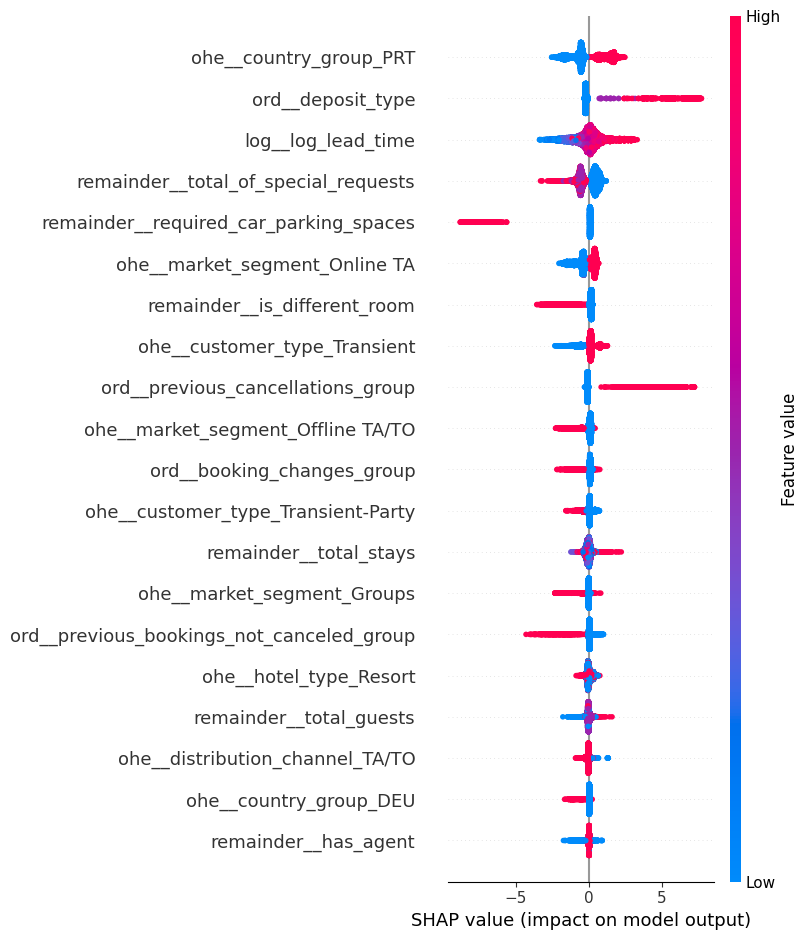

In [33]:
shap.summary_plot(shap_values, X_test_trans)

Dựa vào biểu đồ trên cho thấy:
- Các thuộc tính nổi bật kéo tỉ lệ hủy cao:
    - deposit_type là Non-refund (như phần EDA đã trình bày).
    - lead_time dài
    - previous_cancellations_group lớn

- Các thuộc tính nổi bật kéo tỉ lệ hủy xuống:
    - required_parking_spaces: có nhu cầu đỗ xe
    - total_special_requests: khách có nhiều yêu cầu
    - previous_bookings_not_canceled: số lần đặt trước mà không hủy
    - country: khách không phải là đến từ Bồ Đào Nha (PRT)



In [34]:
X_test_trans

array([[4.79579055, 0.        , 0.        , ..., 2.        , 4.        ,
        0.        ],
       [5.20400669, 0.        , 0.        , ..., 2.        , 2.        ,
        0.        ],
       [5.61312811, 0.        , 0.        , ..., 2.        , 9.        ,
        0.        ],
       ...,
       [1.79175947, 0.        , 0.        , ..., 2.        , 1.        ,
        1.        ],
       [4.66343909, 0.        , 0.        , ..., 2.        , 1.        ,
        0.        ],
       [0.69314718, 0.        , 0.        , ..., 1.        , 2.        ,
        0.        ]])

### Giải thích trên 1 mẫu bị False Negative

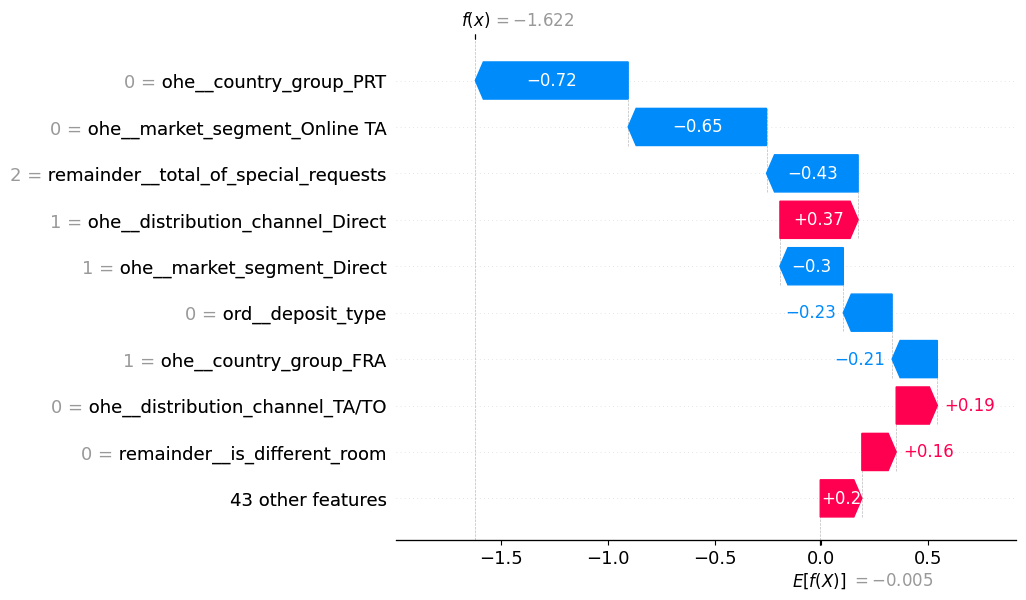

In [35]:
shap.plots.waterfall(shap_values[17528])

Dựa vào biểu đồ trên:
- Giá trị log-odds = -1.622 -> p = 0.16 -> mô hình sẽ phân lớp 0.
- Nhưng nhãn lại là 1. -> tức mô hình phân lớp sai.
Giải thích:
- Các giá trị làm mô hình lệch hẳn sang lớp 0:
    - Quốc gia của khách không phải là PRT (Bồ Đào Nha) (khớp với giải thích mô hình ở summary plot của SHAP bên trên)
    - Thị trường của khách không phải là trong đại lý online mà là trực tiếp
    - Số lượng yêu cầu nhiều (khớp với giải thích mô hình ở summary plot của SHAP bên trên)
    - Loại đặt cọc là No deposit

